# Web Scraping

In [1]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select
from bs4 import BeautifulSoup
import requests
import time
import pickle
import os

import datetime as dt 
import pandas as pd
pd.options.display.max_columns=100
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import ast

headers = {
    "User-Agent": "My Custom User Agent",
    "Accept": "application/json",
}

import warnings
warnings.filterwarnings('ignore')

In [ ]:
driver=webdriver.Edge()
driver.maximize_window()

In [ ]:
home_url="https://www.carsforsale.com/" #not the actual website

In [ ]:
driver.get(home_url)

In [ ]:
shop_page=WebDriverWait(driver,10).until(expected_conditions.element_to_be_clickable((By.CSS_SELECTOR,'div[class="footer-links"] a[data-click-intent-id="shop-link"]')))
driver.execute_script('arguments[0].click();',shop_page)

In [ ]:
dropdown_element=WebDriverWait(driver,10).until(expected_conditions.element_to_be_clickable((By.CSS_SELECTOR,'div[class="sds-pagination"] select[id="pagination-dropdown"]')))
select_article_quantity=Select(dropdown_element).select_by_index(4)

In [ ]:
all_urls=[]

while True:
    next_page_button=WebDriverWait(driver,10).until(expected_conditions.element_to_be_clickable((By.CSS_SELECTOR,'div[class="sds-pagination__controls"] a[id="next_paginate"]')))
    driver.execute_script('arguments[0].scrollIntoView();',next_page_button)
    time.sleep(1)

    articles=WebDriverWait(driver,30).until(expected_conditions.visibility_of_all_elements_located((By.CSS_SELECTOR,'div[class="vehicle-cards"] div[class="vehicle-card vehicle-card-with-reviews ep-theme-hubcap"] a[class="vehicle-card-link js-gallery-click-link"]')))
    for article in articles:
        all_urls.append(article.get_attribute('href'))
    time.sleep(1)
    print(len(all_urls),end='\r')

    driver.execute_script('arguments[0].click();',next_page_button)
    time.sleep(3)

    

In [2]:
path=r'D:\python data\ws_cars'

In [ ]:
#pickle.dump(all_urls,open(os.path.join(path,'all_urls.pickle'),'wb'))
all_urls=pickle.load(open(os.path.join(path,'all_urls.pickle'),'rb'))

In [ ]:
all_urls=list(set(all_urls))
len(all_urls)

In [ ]:
def return_info_dict(car_url):
    try:
        soup=BeautifulSoup(requests.get(car_url).content,'html.parser')
    except:
        pass

    #Main info
    try:
        condition=soup.select_one('div[class="title-section"] p[class="new-used"]').text.replace('\n','')
    except:
        condition=None
        
    try:
        car=soup.select_one('div[class="title-section"] h1[class="listing-title"]').text.replace('\n','')
    except:
        car=None
        
    try:
        mileage=soup.select_one('div[class="title-section"] div[class="listing-mileage"]').text.replace('\n','')
    except:
        mileage=None
        
    try:
        price=soup.select_one('div[class="price-section"]').text.replace('\n','')
    except:
        price=None
        

    #Basics
    try:
        basics_section_keys=soup.select('div[class="basics-content-wrapper"] section[class="sds-page-section basics-section"] dl[class="fancy-description-list"] dt')
        basics_section_values=soup.select('div[class="basics-content-wrapper"] section[class="sds-page-section basics-section"] dl[class="fancy-description-list"] dd')
        basics_dict={}
        for key,value in zip(basics_section_keys,basics_section_values):
            key=key.text.replace('\n','')
            value=value.text.replace('\n','')
            basics_dict[key]=value
    except:
        basics_dict=None

    #Vehicle hist
    try:
        history_section_keys=soup.select('section[class="sds-page-section vehicle-history-section"] dl[class="fancy-description-list"] dt')
        history_section_values=soup.select('section[class="sds-page-section vehicle-history-section"] dl[class="fancy-description-list"] dd')
        history_dict={}
        for key,value in zip(history_section_keys,history_section_values):
            key=key.text.replace('\n','')
            value=value.text.replace('\n','')
            history_dict[key]=value
    except:
        history_dict=None

    #seller info
    try:
        seller_rating=soup.select_one('section[class="seller-info"] div[class="sds-rating"] span[class="sds-rating__count"]').text.replace('\n','')
    except:
        seller_rating=None
        
    try:
        seller_ratings_count=soup.select_one('section[class="seller-info"] div[class="sds-rating"] a[class="sds-rating__link sds-button-link"]').text.replace('\n','')
    except:
        seller_ratings_count=None
        
    try:
        seller_address=soup.select_one('section[class="seller-info"] div[class="dealer-address"]').text.replace('\n','')
    except:
        seller_address=None
        

    #Vehicle reviews
    try:
        vehicle_reviews_keys=soup.select('div[class="vehicle-reviews"] div[class="review-breakdown"] ul[class="sds-definition-list review-breakdown--list"] li span[class="sds-definition-list__display-name"]')
        vehicle_reviews_values=soup.select('div[class="vehicle-reviews"] div[class="review-breakdown"] ul[class="sds-definition-list review-breakdown--list"] li span[class="sds-definition-list__value"]')
        vehicle_reviews_dict={}
        for key,value in zip(vehicle_reviews_keys,vehicle_reviews_values):
            key=key.text.replace('\n','')
            value=value.text.replace('\n','')
            vehicle_reviews_dict[key]=value
    except:
        vehicle_reviews_dict=None

    info_dict={'Car':car,'Condition':condition,'Mileage':mileage,'Price':price,'Basics Info':basics_dict,'Vehicle History Info':history_dict,'Vehicle Reviews Info':vehicle_reviews_dict,
            'Seller Rating':seller_rating,'Seller Rating Count':seller_ratings_count,'Seller Address':seller_address}

    return info_dict

In [ ]:
max=0
for file in os.listdir(path):
    if 'all_data_' in file:
        index=file.split('all_data_')[-1].split('.pickle')[0]
        index=int(index)
        if index>max:
            max=index
print(f'Max index: {max}')

In [ ]:
all_data=[]
for i,car_url in enumerate(all_urls,start=1):
    if i<=max:
        continue
    info_dict=return_info_dict(car_url)
    all_data.append(info_dict)

    if i%1000==0 or i==len(all_urls):
        pickle.dump(all_data,open(os.path.join(path,f'all_data_{i}.pickle'),'wb'))
        all_data=[]


    print(i,end='\r')


# Preprocessing

In [ ]:
all_info=[]
for file in os.listdir(path):
    if 'all_data_' in file:
        info=pickle.load(open(os.path.join(path,file),'rb'))
        all_info=all_info+info
len(all_info)

In [ ]:
df=pd.DataFrame(all_info)

In [ ]:
df

In [ ]:
df.to_csv(os.path.join(path,'cars_for_sale(uncleaned).csv'),index=False)

In [ ]:
df.isna().sum()

In [ ]:
df=df.dropna(subset='Price')
df=df.reset_index(drop=True)

In [ ]:
make=df['Car'].apply(lambda x:x.split(' ')[1] if isinstance(x,str) else None)
df=df.drop(columns='Make',errors='ignore')
df.insert(0,'Make',make)

In [ ]:
model=df['Car'].apply(lambda x:' '.join(x.split(' ')[1:]) if isinstance(x,str) else None).apply(lambda x:' '.join(x.split(' ')[1:]) if isinstance(x,str) else None)
df=df.drop(columns='Model',errors='ignore')
df.insert(1,'Model',model)

In [ ]:
year=(df['Car'].str.split(' ').str[0]).apply(lambda x: int(x) if x else None)
df.drop(columns='Year',errors='ignore')
df.insert(2,'Year',year)

In [ ]:
df=df.drop(columns='Car')

In [ ]:
df['Condition']=df['Condition'].apply(lambda x:'Certified' if 'Certified' in str(x).title() else x)

In [ ]:
df['Basics Info']=df['Basics Info'].apply(lambda x:x if isinstance(x,dict) and len(x)>0 else None)
df['Vehicle History Info']=df['Vehicle History Info'].apply(lambda x:x if isinstance(x,dict) and len(x)>0 else None)
df['Vehicle Reviews Info']=df['Vehicle Reviews Info'].apply(lambda x:x if isinstance(x,dict) and len(x)>0 else None)

In [ ]:
df['Mileage']=df['Mileage'].apply(lambda x:x.strip().split(' mi')[0].replace(',','') if isinstance(x,str) else None).apply(pd.to_numeric)

In [ ]:
price=df['Price'].apply(lambda x:x.split(' ')[0].split('MSRP')[0].split('$') if isinstance(x,str) else None)
df['Price']=price.apply(lambda x:x[1].replace(',','') if isinstance(x,list) and len(x)>1 else x).apply(pd.to_numeric,errors='coerce')
df['Price']=df['Price'].astype(float)

df=df.dropna(subset='Price')
df=df.reset_index(drop=True)

In [ ]:
basics_df=pd.json_normalize(df['Basics Info']).drop(columns=['Mileage']).reset_index(drop=True)

vehicle_history_df=pd.json_normalize(df['Vehicle History Info']).reset_index(drop=True)

vehicle_reviews_df=pd.json_normalize(df['Vehicle Reviews Info']).reset_index(drop=True)
vehicle_reviews_df.columns=[i+'_score' for i in vehicle_reviews_df.columns]

df=pd.concat([df,basics_df,vehicle_history_df,vehicle_reviews_df],axis=1)

df=df.drop(columns=['Basics Info','Vehicle History Info','Vehicle Reviews Info'])

In [ ]:
df['Seller Rating Count']=df['Seller Rating Count'].apply(lambda x:x.split('(')[-1].split(' ')[0].replace(',','') if isinstance(x,str) else None).apply(pd.to_numeric)

In [ ]:
df['Seller Rating']=df['Seller Rating'].apply(pd.to_numeric)

In [ ]:
min_MPM=df['MPG'].apply(lambda x:x.split('Based')[0].split('–')[0] if isinstance(x,str) else None).apply(pd.to_numeric, errors='coerce')
max_MPM=df['MPG'].apply(lambda x:x.split('Based')[0].split('–')[-1] if isinstance(x,str) else None).apply(pd.to_numeric, errors='coerce')

df.insert(df.columns.get_loc('MPG')+1,'Min MPG',min_MPM)
df.insert(df.columns.get_loc('MPG')+2,'Max MPG',max_MPM)
df=df.drop(columns='MPG')

In [ ]:
df['Fuel type']=df['Fuel type'].replace('– ',None)

In [ ]:
import re

def extract_number_before_L(string):
    pattern = r'(\d+(?:\.\d+)?|\d+)L'
    match = re.search(pattern, string)
    if match:
        return match.group(1)
    else:
        return None
    

engine_size=df['Engine'].apply(extract_number_before_L).apply(pd.to_numeric,errors='coerce')
df.insert(df.columns.get_loc('Engine')+1,'Engine Size (L)',engine_size)
df=df.drop(columns='Engine')

In [ ]:
df['Accidents or damage']=df['Accidents or damage'].map({'At least 1 accident or damage reported':1,'None reported':0})
df['Open recall']=df['Open recall'].apply(lambda x:1 if 'At least 1 open recall reported' in str(x) else 0)

In [ ]:
df=df.replace({'Yes':True,'No':False})

In [ ]:
df=df.replace({'–':None})

In [ ]:
df[df.columns[df.columns.str.contains('_score')].values]=df[df.columns[df.columns.str.contains('_score')].values].apply(pd.to_numeric,errors='coerce')

In [ ]:
columns_to_drop=['Seller Address','VIN','Stock #']
df=df.drop(columns=columns_to_drop)

In [ ]:
df.info()

In [ ]:
for col in df.select_dtypes([object,bool]).columns:
    try:
        print(col,df[col].nunique())
    except:
        print(col)

In [ ]:
columns_to_drop=['Model','Exterior color','Transmission']
df=df.drop(columns=columns_to_drop)

In [ ]:
for col in df.select_dtypes([object,bool]).columns:
    try:
        print(col,df[col].nunique())
    except:
        print(col)

In [ ]:
df.isna().mean()*100

In [ ]:
df.to_csv(os.path.join(path,'cars_for_sale(cleaned).csv'),index=False)

# Machine Learning

In [3]:
df=pd.read_csv(os.path.join(path,'cars_for_sale(cleaned).csv'))

In [4]:
df

,Make,Year,Condition,Mileage,Price,Seller Rating,Seller Rating Count,Interior color,Drivetrain,Min MPG,Max MPG,Fuel type,Engine Size (L),Accidents or damage,1-owner vehicle,Personal use only,Clean title,Open recall,Comfort_score,Interior_score,Performance_score,Value_score,Exterior_score,Reliability_score
0,Lexus,2024,New,0.0,112865.0,4.7,1261.0,Black,Rear-wheel Drive,15.0,25.0,Gasoline,5.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1,Acura,2007,Used,61110.0,11295.0,4.2,440.0,–,Front-wheel Drive,22.0,31.0,Gasoline,2.4,1.0,True,True,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2,McLaren,2016,Used,6305.0,219997.0,3.1,421.0,Carbon Black,Rear-wheel Drive,NaN,NaN,Gasoline,3.8,1.0,False,False,NaN,0,5.0,5.0,5.0,5.0,5.0,5.0
3,Audi,2016,Used,65715.0,23999.0,3.6,123.0,Black,All-wheel Drive,23.0,27.0,Gasoline,2.0,1.0,False,True,True,0,3.0,5.0,5.0,5.0,5.0,5.0
4,BMW,2018,Used,19830.0,39799.0,4.4,91.0,Black,All-wheel Drive,0.0,0.0,Gasoline,2.0,0.0,True,False,True,0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9011,Jeep,2024,New,10.0,52301.0,4.0,54.0,Global Black,Four-wheel Drive,18.0,25.0,Gasoline,3.6,NaN,NaN,NaN,NaN,0,5.0,5.0,5.0,5.0,5.0,5.0
9012,BMW,2022,Used,48804.0,27979.0,4.8,3739.0,Canberra Beige,All-wheel Drive,21.0,28.0,Gasoline,2.0,0.0,True,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
9013,GMC,2024,New,3.0,51080.0,4.5,3896.0,Black,Four-wheel Drive,17.0,20.0,Gasoline,5.3,NaN,NaN,NaN,NaN,0,5.0,5.0,5.0,4.0,5.0,5.0
9014,GMC,2012,Used,146694.0,8995.0,NaN,NaN,Jet Black,All-wheel Drive,20.0,22.0,Gasoline,2.4,1.0,False,True,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.isna().mean()

Make                   0.000000
Year                   0.000000
Condition              0.000000
Mileage                0.016526
Price                  0.000000
Seller Rating          0.150288
Seller Rating Count    0.150288
Interior color         0.000000
Drivetrain             0.000000
Min MPG                0.176908
Max MPG                0.176908
Fuel type              0.063776
Engine Size (L)        0.084849
Accidents or damage    0.401065
1-owner vehicle        0.403949
Personal use only      0.401065
Clean title            0.852374
Open recall            0.000000
Comfort_score          0.513531
Interior_score         0.513531
Performance_score      0.513531
Value_score            0.513531
Exterior_score         0.513531
Reliability_score      0.521961
dtype: float64

In [6]:
for col in df.select_dtypes([object]).columns:
    dummies=pd.get_dummies(df[col],prefix=col,dummy_na=False)
    df=df.drop(columns=col)
    df=pd.concat([df,dummies],axis=1)

In [7]:
df.shape

(9016, 711)

In [8]:
X=df.drop(columns='Price')
y=df['Price']

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

X_train_as_np, X_test_as_np ,y_train_as_np ,y_test_as_np = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test) 

In [9]:
from xgboost import XGBRegressor
best_model=XGBRegressor()

In [10]:
best_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
train_prediction=best_model.predict(X_train)
test_prediction=best_model.predict(X_test)

In [12]:
from sklearn import metrics
r2_train=metrics.r2_score(train_prediction,y_train)
r2_test=metrics.r2_score(test_prediction,y_test)
mae_train=metrics.mean_absolute_error(train_prediction,y_train)
mae_test=metrics.mean_absolute_error(test_prediction,y_test)
rmse_train=metrics.mean_squared_error(train_prediction,y_train,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,y_test,squared=False)
train_scores={'R2_train':r2_train,'MAE_train':mae_train,'RMSE_train':rmse_train}
test_scores={'R2_test':r2_test,'MAE_test':mae_test,'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)

{'R2_train': 0.9845983203061889, 'MAE_train': 3685.616536830705, 'RMSE_train': 5429.643127407667}
{'R2_test': 0.9333146322598123, 'MAE_test': 4714.329515410633, 'RMSE_test': 8157.184267805375}


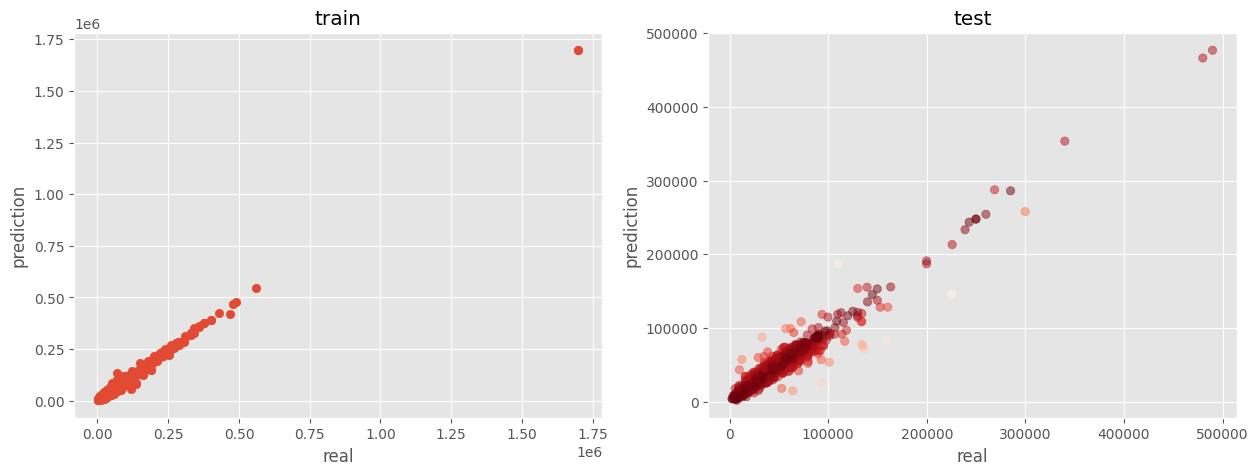

In [13]:
abs_error=np.abs(y_test-test_prediction)

fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(y_train,train_prediction)
ax1.set_xlabel('real')
ax1.set_ylabel('prediction')
ax1.set_title('train')
ax2.scatter(y_test,test_prediction,c=abs_error,cmap='Reds_r',alpha=0.5)
ax2.set_xlabel('real')
ax2.set_ylabel('prediction')
ax2.set_title('test')
plt.show()

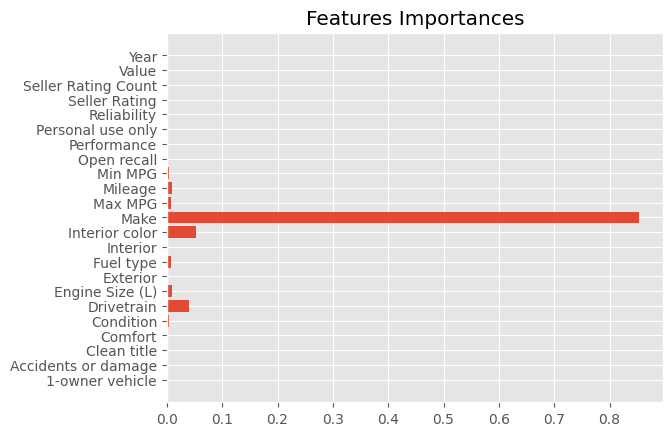

In [14]:
feature_names=best_model.feature_names_in_
weights=best_model.feature_importances_

weights_df=pd.DataFrame({'feature_names':feature_names,'weights':weights})
weights_df_grouped=weights_df.groupby(weights_df['feature_names'].str.split('_').str[0])['weights'].sum()

plt.barh(y=weights_df_grouped.index,width=weights_df_grouped.values)
plt.title('Features Importances')
plt.show()